# Sentinel-2 processing with eodag, Sen2Cor and SNAP : burnt areas mapping with gpt
__________

At the end of May 2018 a wildfire began in the North of New Mexico next to Cimarron in Ute Park area. The fire burnt a minimum of 36,000 acres (14,569 hectares) of drought-parched grassland and timber (source: [Express](http://web.archive.org/web/20180605150346/https://www.express.co.uk/news/world/969726/ute-park-fire-new-mexico-where-wildfire-spread-ute-park-map-NFSA)).


In this tutorial we use `eodag` to recover a stack of data on the same tile and processing it with *SNAP* to get a burned area mask that we will display on a dynamic map to evaluate the extent of damage.

To be able to follow this tutorial, you will need to install:

* [Sen2Cor](http://step.esa.int/main/third-party-plugins-2/sen2cor/): the installation instructions of the version used in this notebook (2.5.5) are provided in [this online PDF file](http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-SRN-V2.5.5.pdf). To use *Sen2Cor* and its `L2A_Process` command you need to have its `bin` folder in your system *PATH*.
* [SNAP](http://step.esa.int/main/download/snap-download/) to use its `gpt` command. This particular command is used to execute *SNAP* raster data operators in batch-mode based on XML Graph files (see more info about the [Graph Processing Framework](https://senbox.atlassian.net/wiki/spaces/SNAP/pages/70503590/Creating+a+GPF+Graph) of *SNAP*). As with Sen2Cor you need to have the `bin` folder of *SNAP* in your system *PATH*. The version used in this tutorial is the 8.0.
* The following Python packages: [Folium](https://python-visualization.github.io/folium/installing.html), [imageio](https://imageio.readthedocs.io/en/stable/installation.html), [Matplotlib](https://matplotlib.org/3.3.3/users/installing.html), [NumPy](https://numpy.org/install/) and [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html).

## Configuration

Let's start by setting your personal credentials to access [PEPS service](https://peps.cnes.fr) by filling your username and password below:

In [1]:
import os
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

If you don't have the `bin` folders of *Sen2Cor* and *SNAP* in your system *PATH* uncomment the following lines of code, adapt the paths to your installations and run it to check whether the paths were correctly prepended to your *PATH*.

In [2]:
# Add absolute path to Sen2Cor bin folder to make the L2A_Process command available
#os.environ["PATH"] = "PLEASE_CHANGE_ME" + ":" + os.environ["PATH"]
# Add absolute path to SNAP bin folder to make the gpt command available 
#os.environ["PATH"] = "PLEASE_CHANGE_ME" + ":" + os.environ["PATH"]

Let's check that the Python packages required to run this notebook are available:

In [3]:
import folium
import imageio
import matplotlib.pyplot as plt
import numpy as np
import rasterio

We create a workspace directory where all our files and configuration will live. We also start the `EODataAccessGateway` instance that we will use to search and download data from *PEPS*. 

In [4]:
from eodag.api.core import EODataAccessGateway
from eodag.utils.logging import setup_logging

setup_logging(verbose=1)

# Create the workspace folder.
workspace = 'eodag_workspace_fire_gpt'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

# Save the PEPS configuration file.
yaml_content = """
peps:
    download:
        outputs_prefix: "{}"
        extract: true
""".format(os.path.abspath(workspace))

with open(os.path.join(workspace, 'eodag_conf.yml'), "w") as f_yml:
    f_yml.write(yaml_content.strip())

dag = EODataAccessGateway(os.path.join(workspace, 'eodag_conf.yml'))

2021-01-11 21:03:52,719-15s eodag.config                     [INFO    ] Loading user configuration from: /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace/eodag_conf.yml
2021-01-11 21:03:52,993-15s eodag.core                       [INFO    ] Locations configuration loaded from /home/maxime/.config/eodag/locations.yml


## Search and download with `eodag`

We define the type of product we want to work on and the search area.

In [5]:
product_type = 'S2_MSI_L1C'
extent = {
    'lonmin': -105.095901,
    'lonmax': -104.977112,
    'latmin': 36.500253,
    'latmax': 36.559015
}

We want to frame the fire period by studying two images before and after, at the end of May and at the beginning of June.

In [6]:
products_before, _ = dag.search(
    productType=product_type,
    start='2018-05-21', 
    end='2018-05-25',
    geom=extent,
)
products_before

2021-01-11 21:03:58,915-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2021-01-11 21:03:58,916-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-05-21&completionDate=2018-05-25&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=1&page=1
2021-01-11 21:03:59,214-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-05-21&completionDate=2018-05-25&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=20&page=1
2021-01-11 21:03:59,541-15s eodag.core                       [INFO    ] Found 2 result(s) on provider 'peps'


[EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SEA_20180524T225950, provider=peps), EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950, provider=peps)]

In [7]:
products_after, _ = dag.search(
    productType=product_type,
    start='2018-06-06',
    end='2018-06-10',
    geom=extent,
)
products_after

2021-01-11 21:04:01,305-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2021-01-11 21:04:01,308-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-06-06&completionDate=2018-06-10&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=1&page=1
2021-01-11 21:04:01,752-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-06-06&completionDate=2018-06-10&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=20&page=1
2021-01-11 21:04:02,236-15s eodag.core                       [INFO    ] Found 2 result(s) on provider 'peps'


[EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SEA_20180608T211610, provider=peps)]

We have now two sets of products which overlaps our region of interest, one before the fire took place and one after. We would like to work with the products that cover the most the burned area. `eodag` provides a handy utility that can group the products obtained from multiple searches by their extent, i.e. their bounding box. We will use this utility to find out which tiles we want to work with:

In [9]:
sorted_products = dag.group_by_extent([products_before, products_after])
sorted_products

[[EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SEA_20180524T225950, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SEA_20180608T211610, provider=peps)],
 [EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610, provider=peps)]]

In [10]:
len(sorted_products)

2

The utility constructed two different groups which means that we can choose between two extents. As can be seen from their names, the tiles available are `T13SEA` and `T13SDA`. We display the two groups on a map with a tooltip (move your mouse over the polygons) to display their title:

In [11]:
emap = folium.Map([36, -105], zoom_start=7)
layer_0 = folium.features.GeoJson(
    data=sorted_products[0].as_geojson_object(),
    style_function=lambda x: {'fillColor': 'red'},
    tooltip=folium.GeoJsonTooltip(fields=['title']),
).add_to(emap)
layer_1 = folium.features.GeoJson(
    data=sorted_products[1].as_geojson_object(),
    style_function=lambda x: {'fillColor': 'yellow'},
    tooltip=folium.GeoJsonTooltip(fields=['title']),
).add_to(emap)
emap

We can see that our region of interest is best covered by the tile in yellow: **T13SDA**. We select the related products which are stored in the second group returned by `group_by_extent`.

In [13]:
selected_products = sorted_products[1]
selected_products

[EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610, provider=peps)]

Our two products of interest appear to be conveniently ordered by date, the first corresponding to May, 24th and the second one to June, 8th. We can now download them:

In [14]:
from eodag.utils import NotebookProgressCallback

paths = [
    product.download(progress_callback=NotebookProgressCallback()) 
    for product in selected_products
]
paths

2021-01-11 21:05:56,987-15s eodag.plugins.download.base      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/f593c509-b7c4-5fd2-829b-8eab51236b6a/download


2021-01-11 21:06:18,220-15s eodag.plugins.download.base      [INFO    ] Extraction activated

Extracting files from S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.zip:   0%|          | 0/115 [00:00<?, ?file/s]
Extracting files from S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.zip:  80%|████████  | 92/115 [00:00<00:00, 731.30file/s]
Extracting files from S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.zip: 100%|██████████| 115/115 [00:01<00:00, 87.36file/s]
2021-01-11 21:06:19,541-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/f593c509-b7c4-5fd2-829b-8eab51236b6a/download
2021-01-11 21:06:19,541-15s eodag.plugins.download.base      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/617aceed-0bb5-5f79-9ba2-c2e3cfbeca49/download


2021-01-11 21:06:46,430-15s eodag.plugins.download.base      [INFO    ] Extraction activated


Extracting files from S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610.zip:   0%|          | 0/115 [00:00<?, ?file/s]

Extracting files from S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610.zip:  79%|███████▉  | 91/115 [00:00<00:00, 582.12file/s]

Extracting files from S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610.zip: 100%|██████████| 115/115 [00:01<00:00, 79.64file/s]
2021-01-11 21:06:47,882-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/617aceed-0bb5-5f79-9ba2-c2e3cfbeca49/download


['file:///home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.SAFE',
 'file:///home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610.SAFE']

## Post-process the products with *Sen2Cor* and *SNAP*

We now run *Sen2Cor* that provides atmospheric correction of S2-L1C products and creates S2-L2A products (this process may take a while):

In [15]:
for prod in paths:
    prod = prod[len('file://'):] if prod.startswith('file://') else prod
    print("Processing with L2A_Process:", prod, "...\n")
    # create folder if it doesn't exist
    if not os.path.exists(os.path.join(prod, 'AUX_DATA')):
        os.makedirs(os.path.join(prod, 'AUX_DATA'))
    ! L2A_Process {prod}

Processing with L2A_Process: /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.SAFE ...


Sentinel-2 Level 2A Processor (Sen2Cor). Version: 2.5.5, created: 2018.03.19, supporting Level-1C product version <= 14.5 started ...
Product version: 14.5. Operation mode: PDGS. Processing baseline: 02.06.
 No resolution specified, will process all resolutions.
Progress[%]: 0.01 : PID-30650, L2A_ProcessTile: processing with resolution 60 m, elapsed time[s]: 0.232, total: 0:00:01.386466
Progress[%]: 0.01 : PID-30650, L2A_ProcessTile: start of pre processing, elapsed time[s]: 0.000, total: 0:00:01.386703
Progress[%]: 0.01 : PID-30650, L2A_Tables: start import, elapsed time[s]: 0.046, total: 0:00:01.432644
Progress[%]: 0.04 : PID-30650, L2A_Tables: band B01 imported, elapsed time[s]: 0.909, total: 0:00:02.342040
Progress[%]: 0.93 : PID-30650, L2A_Tables: band B02 impor

Progress[%]: 7.02 : PID-30650, L2A_Tables: band B09 exported, elapsed time[s]: 1.450, total: 0:03:20.584827
Progress[%]: 7.07 : PID-30650, L2A_Tables: band B11 exported, elapsed time[s]: 1.523, total: 0:03:22.107587
Progress[%]: 7.12 : PID-30650, L2A_Tables: band B12 exported, elapsed time[s]: 1.443, total: 0:03:23.550202
Progress[%]: 7.13 : PID-30650, L2A_Tables: band SCL exported, elapsed time[s]: 0.216, total: 0:03:23.766689
Progress[%]: 7.13 : PID-30650, L2A_Tables: band SNW exported, elapsed time[s]: 0.124, total: 0:03:23.891014
Progress[%]: 7.14 : PID-30650, L2A_Tables: band CLD exported, elapsed time[s]: 0.124, total: 0:03:24.015063
Progress[%]: 7.14 : PID-30650, L2A_Tables: band AOT exported, elapsed time[s]: 0.088, total: 0:03:24.103179
Progress[%]: 7.17 : PID-30650, L2A_Tables: band WVP exported, elapsed time[s]: 0.821, total: 0:03:24.923715
Progress[%]: 7.18 : PID-30650, L2A_Tables: band PVI exported, elapsed time[s]: 0.257, total: 0:03:25.181046
Progress[%]: 7.26 : PID-3065

Progress[%]: 31.75 : PID-30650, L2A_Tables: band B03 exported, elapsed time[s]: 9.728, total: 0:15:03.329047
Progress[%]: 32.12 : PID-30650, L2A_Tables: band B04 exported, elapsed time[s]: 10.524, total: 0:15:13.853193
Progress[%]: 32.48 : PID-30650, L2A_Tables: band B05 exported, elapsed time[s]: 10.123, total: 0:15:23.975936
Progress[%]: 32.83 : PID-30650, L2A_Tables: band B06 exported, elapsed time[s]: 10.138, total: 0:15:34.113883
Progress[%]: 33.20 : PID-30650, L2A_Tables: band B07 exported, elapsed time[s]: 10.394, total: 0:15:44.507797
Progress[%]: 33.58 : PID-30650, L2A_Tables: band B8A exported, elapsed time[s]: 10.672, total: 0:15:55.179476
Progress[%]: 33.97 : PID-30650, L2A_Tables: band B11 exported, elapsed time[s]: 11.341, total: 0:16:06.520771
Progress[%]: 34.35 : PID-30650, L2A_Tables: band B12 exported, elapsed time[s]: 10.735, total: 0:16:17.256031
Progress[%]: 34.39 : PID-30650, L2A_Tables: band SCL exported, elapsed time[s]: 1.192, total: 0:16:18.447706
Progress[%]:

Progress[%]: 5.60 : PID-544, L2A_CSND_2_3  , elapsed time[s]: 0.068, total: 0:02:45.150985
Progress[%]: 5.61 : PID-544, L2A_CSND_2_4  , elapsed time[s]: 0.122, total: 0:02:45.272909
Progress[%]: 5.61 : PID-544, L2A_CSND_2_5  , elapsed time[s]: 0.185, total: 0:02:45.458065
Progress[%]: 5.61 : PID-544, L2A_SnowPostProcessingCCI  , elapsed time[s]: 0.001, total: 0:02:45.459155
Progress[%]: 5.62 : PID-544, L2A_CSND_3    , elapsed time[s]: 0.257, total: 0:02:45.715877
Progress[%]: 5.63 : PID-544, L2A_CSND_5_1  , elapsed time[s]: 0.196, total: 0:02:45.912293
Progress[%]: 5.64 : PID-544, L2A_CSND_5_2  , elapsed time[s]: 0.323, total: 0:02:46.235740
Progress[%]: 5.65 : PID-544, L2A_CSND_6    , elapsed time[s]: 0.237, total: 0:02:46.473104
Progress[%]: 5.65 : PID-544, L2A_CSND_6_2  , elapsed time[s]: 0.143, total: 0:02:46.615858
Progress[%]: 5.66 : PID-544, L2A_CSND_7    , elapsed time[s]: 0.145, total: 0:02:46.760439
Progress[%]: 5.78 : PID-544, L2A_SHD       , elapsed time[s]: 3.661, total: 0

Progress[%]: 14.10 : PID-544, L2A_CSND_1_1  , elapsed time[s]: 1.214, total: 0:06:53.110379
Progress[%]: 14.14 : PID-544, L2A_CSND_1_2  , elapsed time[s]: 1.273, total: 0:06:54.383110
Progress[%]: 14.14 : PID-544, L2A_CSND_2_0  , elapsed time[s]: 0.091, total: 0:06:54.474281
Progress[%]: 14.18 : PID-544, L2A_CSND_2_1  , elapsed time[s]: 1.165, total: 0:06:55.639512
Progress[%]: 14.21 : PID-544, L2A_CSND_2_1_2, elapsed time[s]: 0.854, total: 0:06:56.493151
Progress[%]: 14.23 : PID-544, L2A_CSND_2_2  , elapsed time[s]: 0.585, total: 0:06:57.077763
Progress[%]: 14.25 : PID-544, L2A_CSND_2_3  , elapsed time[s]: 0.549, total: 0:06:57.627035
Progress[%]: 14.28 : PID-544, L2A_CSND_2_4  , elapsed time[s]: 0.990, total: 0:06:58.616707
Progress[%]: 14.34 : PID-544, L2A_CSND_2_5  , elapsed time[s]: 1.736, total: 0:07:00.352428
Progress[%]: 14.34 : PID-544, L2A_SnowPostProcessingCCI  , elapsed time[s]: 0.001, total: 0:07:00.353830
Progress[%]: 14.42 : PID-544, L2A_CSND_3    , elapsed time[s]: 2.18

Progress[%]: 21.88 : PID-544, L2A_AtmCorr: end of resampling visibility for 10 m resolution, elapsed time[s]: 2.294, total: 0:21:25.964838
Progress[%]: 21.97 : PID-544, L2A_AtmCorr: end of AOT retrieval at 550nm, elapsed time[s]: 2.699, total: 0:21:28.664262
Progress[%]: 21.97 : PID-544, L2A_AtmCorr: preparation of surface reflectance retrieval, elapsed time[s]: 0.000, total: 0:21:28.664617
Progress[%]: 22.07 : PID-544, L2A_AtmCorr: end of surface reflectance retrieval preparation, elapsed time[s]: 2.717, total: 0:21:31.381469
Progress[%]: 32.65 : PID-544, L2A_AtmCorr: end of surface reflectance retrieval, elapsed time[s]: 183.320, total: 0:24:34.701344
Progress[%]: 35.81 : PID-544, L2A_AtmCorr: end of rho retrieval step 2, elapsed time[s]: 92.325, total: 0:26:07.026840
Progress[%]: 35.81 : PID-544, L2A_ProcessTile: start of post processing, elapsed time[s]: 0.087, total: 0:26:07.114220
Progress[%]: 35.81 : PID-544, L2A_Tables: start export, elapsed time[s]: 0.000, total: 0:26:07.11470

In [16]:
# Create the paths of the output directories for L2A_Process
l2a_paths = []
for p in paths:
    splitted_path = p.split('/')
    splitted_path[-1] = splitted_path[-1].replace('L1C', 'L2A')
    new_path = '/'.join(splitted_path)
    new_path = new_path[len('file://'):] if new_path.startswith('file://') else new_path
    l2a_paths.append(new_path)
l2a_paths

['/home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950/S2A_MSIL2A_20180524T174051_N0206_R098_T13SDA_20180524T225950.SAFE',
 '/home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610/S2B_MSIL2A_20180608T173859_N0206_R098_T13SDA_20180608T211610.SAFE']

We write the first graph to pre-process the products. The idea is to isolate the bands of interest and resample them, then create a cloud mask and a first bandmath: the Normalized Burn Ratio (NBR). With the merge, we keep all the output bands into the same product. Finally, we apply it to the two images to compare the NBR result.

In [17]:
graph_preprocess = os.path.join(workspace, 'BurnedAreas_NBR.xml')
with open(graph_preprocess, 'w') as g_1:
    g_1.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Resample">
      <operator>Resample</operator>
        <sources>
          <sourceProduct refid="Read"/>
        </sources>
      <parameters>
        <referenceBand>B2</referenceBand>
      </parameters>
    </node>
    <node id="BandMaths">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="Resample"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>CloudMask</name>
            <type>float32</type>
            <expression>
                if (scl_cloud_medium_proba || scl_cloud_high_proba || scl_thin_cirrus)
                then 
                    1
                else 
                    0
            </expression>
          </targetBand>
          <targetBand>
            <name>NBR</name>
            <type>float32</type>
            <expression>
                (B8-B12)/(B8+B12)
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="Merge">
      <operator>Merge</operator>
      <sources>
        <masterProduct>Resample</masterProduct>
        <sourceProducts>BandMaths</sourceProducts>
      </sources>
    </node>
    <node id="SubSet">
      <operator>Subset</operator>
      <sources>
        <sourceProduct refid="Merge"/>
      </sources>
      <parameters>
        <sourceBands>B3,B8,B12,CloudMask,NBR</sourceBands>
        <region>6000,3000,5980,5980</region>
      </parameters>
    </node>
    <node id="Write1">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="SubSet"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
      </parameters>
    </node>
    <node id="Write2">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="SubSet"/>
      </sources>
      <parameters>
        <file>${visu}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

In [18]:
# Before calling gpt, we must set the environment variable LD_LIBRARY_PATH to the current directory
os.environ['LD_LIBRARY_PATH'] = '.'

# Note that this process might take a while...
for input_product, output_product in (
    (l2a_paths[0], os.path.join(workspace, 'preprocessed_before')),
    (l2a_paths[1], os.path.join(workspace, 'preprocessed_after')),
):
    ! gpt {graph_preprocess} -Pinputproduct={input_product} -Poutputproduct={output_product} -Pvisu={output_product}

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.1.0 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
Executing processing graph
INFO: org.esa.s2tbx.dataio.s2.ortho.S2OrthoProductReaderPlugIn: Building product reader - EPSG:32613
INFO: org.hsqldb.persist.Logger: dataFileCache open start


....10%....20%....30%....40%....50%....60%....70%....80%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.1.0 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALV

We can have a look at the NBR band and compare the two dates:

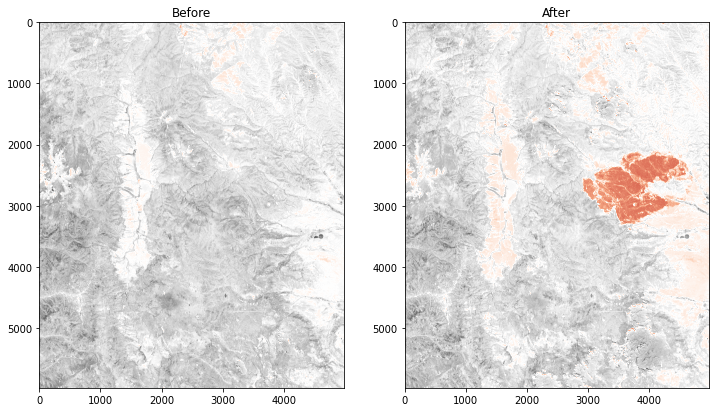

In [19]:
with rasterio.open(os.path.join(workspace, 'preprocessed_before.tif')) as preproc_before:
    burned_areas_before = preproc_before.read()
with rasterio.open(os.path.join(workspace, 'preprocessed_after.tif')) as preproc_after:
    burned_areas_after = preproc_after.read()

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(burned_areas_before[4,:,:], cmap='RdGy')
plt.title('Before')
plt.subplot(122)
plt.imshow(burned_areas_after[4,:,:], cmap='RdGy')
plt.title('After')
plt.show()

Water bodies can show similar NBR difference, like we see it above with a river snaking in the south of the burned area. Therefore, it is necessary to mask them out.
We  also need to mask out clouds occurring in either input image. For this purpose, we will create a single combined water and cloud mask.

To detect  the  water bodies we will use the Normalized Difference Water Index (NDWI).

In [20]:
graph_cloudwatermask = os.path.join(workspace, 'BurnedAreas_CloudWaterMask.xml')
with open(graph_cloudwatermask, 'w') as g_2:
    g_2.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Collocate">
      <operator>Collocate</operator>
      <sources>
        <master>${master}</master>
        <slave>${slave}</slave>
      </sources>
      <parameters>
        <masterComponentPattern>${ORIGINAL_NAME}_May</masterComponentPattern>
        <slaveComponentPattern>${ORIGINAL_NAME}_June</slaveComponentPattern>
      </parameters>
    </node>
    <node id="BandMaths">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="Collocate"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>cloud_water_mask</name>
            <type>float32</type>
            <expression>
                if (CloudMask_May > 0 
                    or CloudMask_June > 0
                    or ((B3_May-B8_May)/(B3_May+B8_May)) >= 0.0)
                then 
                    1
                else
                    0
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="Merge">
      <operator>Merge</operator>
      <sources>
        <masterProduct>Collocate</masterProduct>
        <sourceProducts>BandMaths</sourceProducts>
      </sources>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Merge"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
      </parameters>
    </node>
</graph>

"""
)

In [21]:
! gpt {graph_cloudwatermask} -Smaster={os.path.join(workspace, 'preprocessed_before.dim')} \
    -Sslave={os.path.join(workspace, 'preprocessed_after.dim')} \
    -Poutputproduct={os.path.join(workspace, 'cloudwater_mask')}

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.1.0 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
Executing processing graph
INFO: org.hsqldb.persist.Logger: dataFileCache open start
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.


Finally, we apply the last bandmath, the Relativized Band Ratio (RBR) that takes the two products in input to compute the difference between the first and second date and maximize the burned area delimitation. To discriminate real burned areas from others lands we set a low-value limit at 0.27, corresponding to the minimum where we can affirm that it is a burned area.

In [22]:
graph_RBR = os.path.join(workspace, 'BurnedAreas_RBR.xml')
with open(graph_RBR, 'w') as g_3:
    g_3.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="BandMaths1">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>RBR</name>
            <type>float32</type>
            <expression>
                if cloud_water_mask == 0
                then
                    ((NBR_May - NBR_June) / (NBR_May + 1.001))
                else
                    NaN
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="BandMaths2">
      <operator>BandMaths</operator>
      <sources>
        <sourceProduct refid="BandMaths1"/>
      </sources>
      <parameters>
        <targetBands>
          <targetBand>
            <name>RBR</name>
            <type>float32</type>
            <expression>
                if RBR > 0.27 then RBR else NaN
            </expression>
          </targetBand>
        </targetBands>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="BandMaths2"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>  
</graph>
"""
)

In [23]:
! gpt {graph_RBR} -Pinputproduct={os.path.join(workspace, 'cloudwater_mask.dim')} \
    -Poutputproduct={os.path.join(workspace, 'RBR_product')}

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.1.0 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
Executing processing graph
INFO: org.hsqldb.persist.Logger: dataFileCache open start
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.


We have a final mask that only covers areas actually burned. It can be export as a KMZ to be viewed in Google Earth or any cartographic service. To visualize it on a map, we reduce image resolution and reproject it in mercator projection.

In [24]:
graph_visu = os.path.join(workspace, 'vizualisation.xml')
with open(graph_visu, 'w') as g_4:
    g_4.write(
"""
<graph id="Graph">
  <version>1.0</version>
    <node id="Read">
      <operator>Read</operator>
      <sources/>
      <parameters>
        <file>${inputproduct}</file>
      </parameters>
    </node>
    <node id="Resample">
      <operator>Resample</operator>
      <sources>
        <sourceProduct refid="Read"/>
      </sources>
      <parameters>
        <targetWidth>2232</targetWidth>
        <targetHeight>2472</targetHeight>
      </parameters>
    </node>
    <node id="Write">
      <operator>Write</operator>
      <sources>
        <sourceProduct refid="Resample"/>
      </sources>
      <parameters>
        <file>${outputproduct}</file>
        <formatName>Geotiff</formatName>
      </parameters>
    </node>
</graph>
"""
)

In [25]:
! gpt {graph_visu} -Pinputproduct={os.path.join(workspace, 'RBR_product.tif')} \
    -Poutputproduct={os.path.join(workspace, 'RBR_product_visu')}

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 2.1.0 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 2.1.0 set to be used by SNAP.
Executing processing graph
INFO: org.hsqldb.persist.Logger: dataFileCache open start
...12%..22%..32%...45%...57%..67%..77%...89% done.


In [28]:
# Reproject the image in Mercator 
! rio warp {os.path.join(workspace, 'RBR_product_visu.tif')} {os.path.join(workspace, 'RBR_product_visu_3857.tif')} \
    --dst-crs="EPSG:3857" --resampling="bilinear" --overwrite

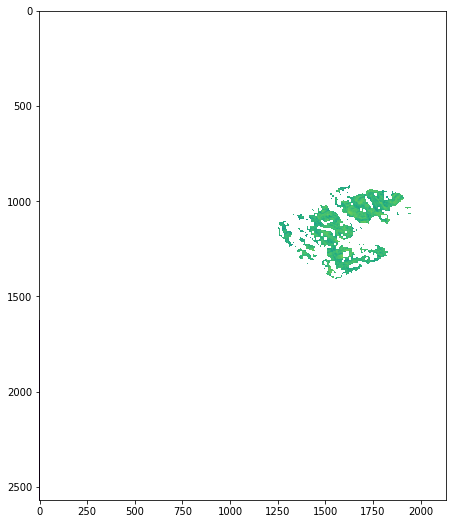

In [29]:
# Display the RBR
with rasterio.open(os.path.join(workspace, 'RBR_product_visu_3857.tif')) as rbr_product:
    burned_areas = rbr_product.read(1)
plt.figure(figsize=(9, 9))
im = plt.imshow(burned_areas)

## Final result

Now we display the mask on a base map like Open Street map:

In [30]:
from folium.raster_layers import ImageOverlay

final_mask = np.zeros((burned_areas.shape[0], burned_areas.shape[1], 4))
final_mask[:,:,3] = burned_areas
imageio.imwrite(os.path.join(workspace, 'burned_areas_gpt.png'), final_mask)

m = folium.Map([36.5, -105], zoom_start=9, tiles='openstreetmap')
ImageOverlay(
    image=os.path.join(workspace, 'burned_areas_gpt.png'),
    name='Mercator projection SW',
    bounds=[[36.2361722222, -105.448691667], [36.7767944444, -104.8907]],
    opacity=1,
).add_to(m)

folium.LayerControl().add_to(m)
m

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
